## 8.3 Methods with seasonality
Holt (1957) and Winters (1960) extended Holt's method to capture seasonality. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level $\ell_t$, one for the trend $b_t$, and one for the seasonal component $s_t$ with corresponding smoothing parameters $\alpha$, $\beta^*$ and $\gamma$. We use $m$ to denote the period of the seasonality, i.e. the number of seasons in a year. For example, for quarterly data $m=4$ and for monthly data $m=12$. 

There are two variations to this method that differ in the nature of the seasonal component. The *additive method* is preferred when the seasonal variations are **roughly constant through the series**, while the *multiplicative method* is preferred when the seasonal variations are **changing proportional to the level of the series**.

With the additive method, the seasonal component is expressed in absolute terms in the scale of the observed series, and in the level equation the series is seasonally adjusted by subtracting the seasonal component. Within each year, the seasonal component will add up to approximately zero.

With the multiplicative method, the seasonal component is expressed in relative terms (percentages), and the series is seasonally adjusted by dividing through by the seasonal component. Within each year, the seasonal component will sum up to approximately $m$.

### Holt-Winters' additive method
The component form for the additive method is:
$$
\begin{align*}
\hat{y}_{t+h|t} & = \ell_t + hb_t + s_{t+h-m(k+1)}\\
\ell_t & = \alpha (y_t - s_{t-m}) + (1-\alpha)(\ell_{t-1} + b_{t-1}) \\
b_t & = \beta^*(\ell_t-\ell_{t-1}) + (1-\beta^*)b_{t-1} \\
s_t & = \gamma(y_t-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}
$$
where $k$ is the integer part of $(h-1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the final year of the sample. The level equation shows a weighted average between the seasonally adjusted observation $(y_t-s_{t-m})$ and the non-seasonal forecast $(\ell_{t-1} + b_{t-1})$ for time $t$. The trend equation is identical to Holt's linear method. The seasonal equation shows a weighted average between the current seasonal index, $(y_t-\ell_{t-1}-b_{t-1})$, and the seasonal index of the same season last year (i.e. $m$ time periods ago).

### Holt-Winters' multiplicative method
The component form for the multiplicative method is:
$$
\begin{align*}
\hat{y}_{t+h|t} & = (\ell_t + hb_t)s_{t+h-m(k+1)}\\
\ell_t & = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(\ell_{t-1} + b_{t-1}) \\
b_t & = \beta^*(\ell_t-\ell_{t-1}) + (1-\beta^*)b_{t-1} \\
s_t & = \gamma\frac{y_t}{(\ell_{t-1}-b_{t-1})} + (1-\gamma)s_{t-m},
\end{align*}
$$

### Example: Australian holidays

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils import *

In [58]:
tourism = (pd.read_csv('../data/tsibble/tourism.csv')
.assign(date=lambda df: pd.to_datetime(df['Quarter'].str.replace(' ', '')
))
)

In [59]:
aus_holidays = (
    tourism.query("Purpose == 'Holiday'")
    .groupby('date')
    .agg({'Trips': 'sum'})
    .reset_index()
    .set_index('date')
    .pipe(set_freq)
)

Note there are multiple implementations of Exponential Smoothing in `statsmodels`. Here we'd like to compare their performance, using the default parameter optimisation for each model.

In [60]:
Y = aus_holidays['Trips']
Y_train = Y.iloc[:-8]
Y_test = Y.iloc[-8:]

In [6]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [75]:
ets_model = ETSModel(Y_train, trend='add', seasonal='add', seasonal_periods=4).fit(disp=0)
expon_sm_model = sm.tsa.ExponentialSmoothing(Y_train, trend='add', seasonal='add').fit()
statespace_sm_model = sm.tsa.statespace.ExponentialSmoothing(Y_train, trend='add', seasonal=4).fit(disp=0)

In [76]:
pred1 = ets_model.forecast(len(Y_test))
pred2 = expon_sm_model.forecast(len(Y_test))
pred3 = statespace_sm_model.forecast(len(Y_test))

In [77]:
from statsmodels.tools.eval_measures import rmse

In [78]:
print(rmse(Y_test, pred1, axis=0))
print(rmse(Y_test, pred2, axis=0))
print(rmse(Y_test, pred3, axis=0))

756.7466173478213
432.09792330499073
435.8777898676149


So we see the Exponential Smoothing implemented in `statsmodels.tsa` has the lowest RMSE (admittedly training on very little data), with the statespace model having similar values, while the `ETSModel` performs the worst. It's not clear why this is - whether `ETSModel` requires more tuning than others. We can plot the forecasts on top of the actual values. We see that the ETS Model is indeed the outlier in predictions - for some reason it's not capturing the trend in the data.

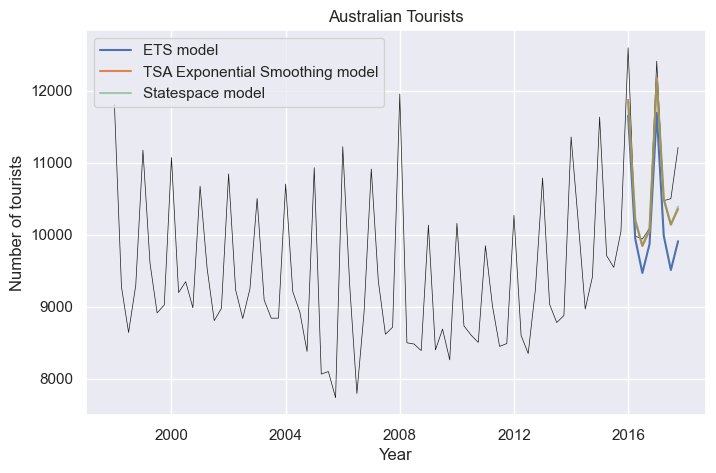

In [79]:
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(Y, 'k', linewidth=0.5)
ax.plot(pred1, label='ETS model')
ax.plot(pred2, label='TSA Exponential Smoothing model')
ax.plot(pred3, label='Statespace model', alpha=0.5)
ax.legend()
ax.set(xlabel='Year', ylabel='Number of tourists', title='Australian Tourists')
plt.show()

`sm.tsa.ExponentialSmoothing` has built-in support for additive and multiplicative components, as does `ETSModel`. Let's first try the `ETSModel`. The multiplicative model looks a little better, but it's still not capturing the trend. I wonder if there's a bug in the implementation.

In [80]:
ets_add = ETSModel(endog=Y_train, trend='add', seasonal='add').fit(disp=0)
ets_mul = ETSModel(endog=Y_train, trend='mul', seasonal='mul').fit(disp=0)

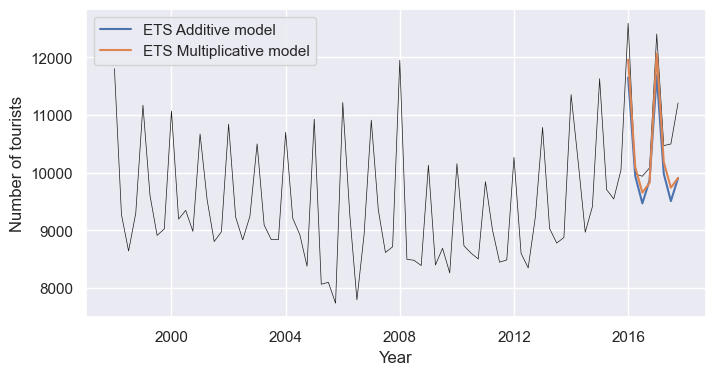

In [87]:
f, ax = plt.subplots(figsize=(8, 4))
ax.plot(Y, 'k', linewidth=0.5)
ax.plot(ets_add.forecast(len(Y_test)), label='ETS Additive model')
ax.plot(ets_mul.forecast(len(Y_test)), label='ETS Multiplicative model')
ax.legend()
ax.set(xlabel='Year', ylabel='Number of tourists')
plt.show()

Now try the `tsa.ExponentialSmoothing` model:

In [82]:
exp_sm_add = sm.tsa.ExponentialSmoothing(Y_train, trend='add', seasonal='add').fit()
exp_sm_mul = sm.tsa.ExponentialSmoothing(Y_train, trend='mul', seasonal='mul').fit()

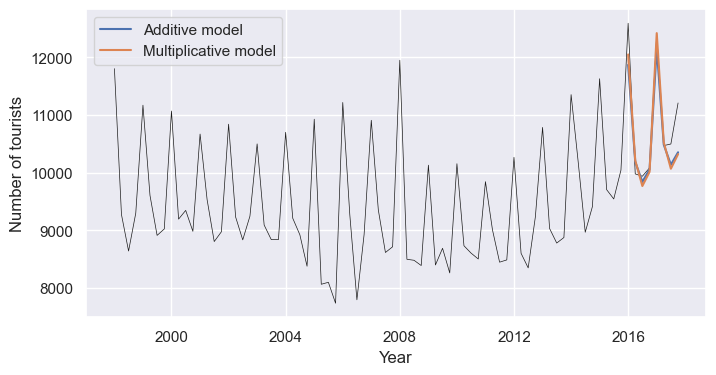

In [88]:
f, ax = plt.subplots(figsize=(8, 4))
ax.plot(Y, 'k', linewidth=0.5)
ax.plot(exp_sm_add.forecast(len(Y_test)), label='Additive model')
ax.plot(exp_sm_mul.forecast(len(Y_test)), label='Multiplicative model')
ax.legend()
ax.set(xlabel='Year', ylabel='Number of tourists')
plt.show()

In [105]:
from utils import summarize_holt

Estimated components for the Holt-Winter method with additive and multiplicative seasonal components

In [106]:
summary_add_model = summarize_holt(exp_sm_add)
summary_mul_model = summarize_holt(exp_sm_mul)

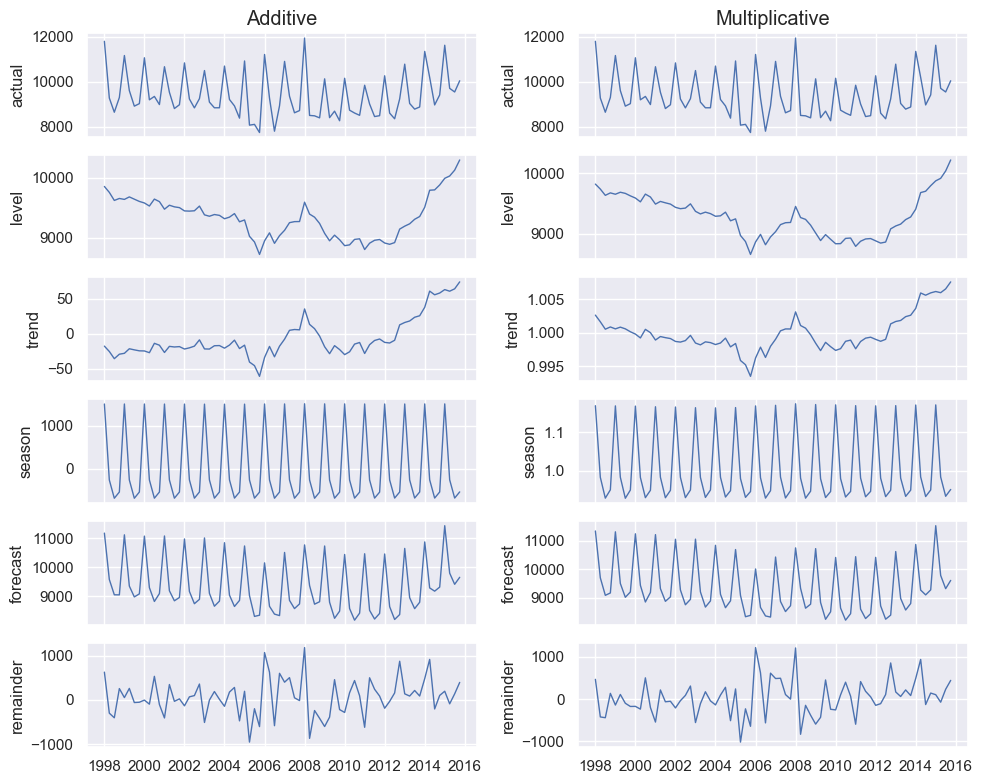

In [107]:
fig, axs = plt.subplots(6, 2, sharex=True, figsize=(10, 8))
for (j, s) in enumerate((summary_add_model, summary_mul_model)):
    for (i, field) in enumerate(summary_add_model.columns):
        ax = axs[i,j]
        ax.plot(s[field], linewidth=1)
        ax.set(ylabel=field)
axs[0,0].set_title('Additive', size='large')
axs[0,1].set_title('Multiplicative', size='large')
plt.tight_layout()

### Holt-Winters' damped method
Damping is possible with both additive and multiplicative Holt-Winters' methods. A method that often provides accurate and robust forecasts for seasonal data is the Holt-Winters method with a damped trend and multiplicative seasonality:
$$
\begin{align*}
    \hat{y}_{t+h|t} &= \left[\ell_t + \left(\phi + \phi^2 + \cdots + \phi^h\right)b_t\right] s_{t+h-m(k+1)} \\
    \ell_t &= \alpha \left(y_t / s_{t-m}\right) + (1 - \alpha)\left(\ell_{t-1} + \phi b_{t-1}\right) \\
    b_t &= \beta^*\left(\ell_t - \ell_{t-1}\right) + (1 - \beta^*)\phi b_{t-1} \\
    s_t &= \gamma \frac{y_t}{\ell_{t-1} + \phi b_{t-1}} + (1 - \gamma)s_{t-m}.
\end{align*}
$$

### Example: Holt-Winters method with daily data

In [119]:
sx_ped = pd.read_csv('../data/tsibble/pedestrian.csv')
sx_ped = (
    sx_ped
    .assign(Date_Time=pd.to_datetime(sx_ped['Date_Time']).dt.tz_localize(None))
    .query("Sensor == 'Southern Cross Station'")
    .query("Date_Time >= '2016-07-01'")
    .set_index('Date_Time')
    .resample('1d').sum()
    .pipe(set_freq)
)[['Time', 'Count']]

In [120]:
sx_ped

,Time,Count
Date_Time,,
2016-07-01,276,11712
2016-07-02,276,2361
2016-07-03,276,8203
2016-07-04,276,17352
2016-07-05,276,16265
...,...,...
2016-12-27,276,3446
2016-12-28,276,5577
2016-12-29,276,4956


In [170]:
split = '2016-08-01'
y_train, y_test = sx_ped[:split], sx_ped[split:'2016-08-31']

In [171]:
damped_model = sm.tsa.ExponentialSmoothing(y_train['Count'], trend='add', damped_trend=True, seasonal='mul').fit()

In [172]:
rmse(y_train['Count'], damped_model.fittedvalues)

np.float64(440.10039970815717)

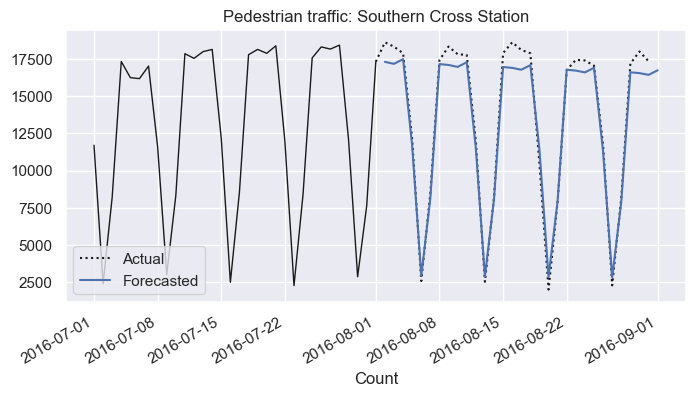

In [173]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_train.Count, 'k', linewidth=1)
ax.plot(y_test.Count, 'k:', label='Actual')

fc = damped_model.forecast(len(y_test))
ax.plot(fc, label='Forecasted')
ax.set(xlabel='Count', title='Pedestrian traffic: Southern Cross Station')
ax.legend()
fig.autofmt_xdate()

In [174]:
statespace_add_model = sm.tsa.statespace.ExponentialSmoothing(y_train['Count'], trend=True, seasonal=7, damped_trend=True).fit(disp=0)

In [175]:
rmse(y_train['Count'], statespace_add_model.fittedvalues)

np.float64(461.3321223505138)

In [176]:
def ciclean(ci_df):
    """Clean up conf_int() result column names."""
    ci_df = ci_df.copy()
    ci_df.columns = 'lower', 'upper'
    return ci_df

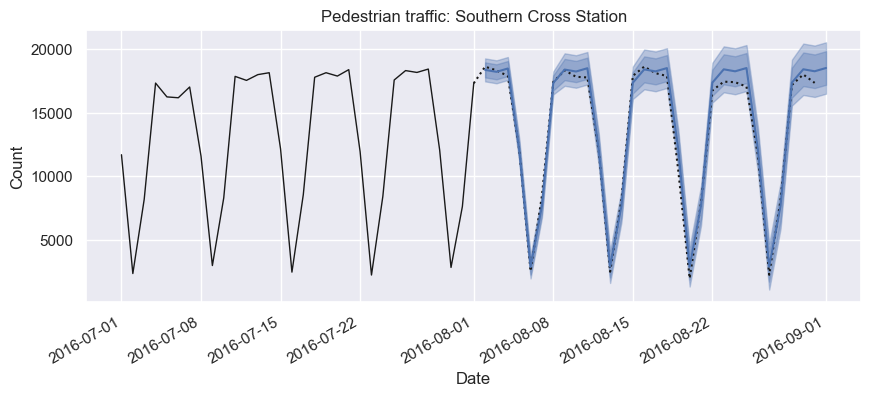

In [177]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_train.Count, 'k', linewidth=1)
ax.plot(y_test[:'2016-09-01'].Count, 'k:')

fc = statespace_add_model.get_forecast(len(y_test))
ax.plot(fc.predicted_mean)

ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, color='C0', alpha=.33)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, color='C0', alpha=.33)

ax.set(xlabel='Date', ylabel='Count', title='Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()

In [180]:
RMSE(y_test.Count, fc.predicted_mean)

np.float64(658.6003134679022)

#### Fit an effectively multiplicative model
If we fit in logspace, then we would effectively have an multiplicative model.

In [181]:
model = sm.tsa.statespace.ExponentialSmoothing(
    np.log1p(y_train['Count']),
    trend=True,
    seasonal=7,
    damped_trend=True
).fit(disp=0)

In [182]:
e1 = np.expm1

In [183]:
RMSE(y_train['Count'], e1(model.fittedvalues))

np.float64(423.56664350507106)

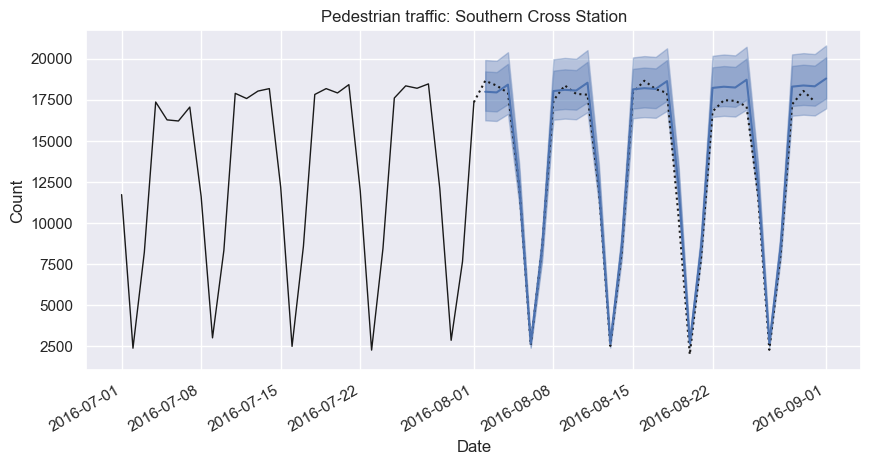

In [184]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_train.Count, 'k', linewidth=1)
ax.plot(y_test.Count, 'k:')

fc = model.get_forecast(len(y_test))
ax.plot(e1(fc.predicted_mean))

ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.33)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.33)

ax.set(xlabel='Date', ylabel='Count', title='Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()

In [185]:
RMSE(y_test.Count, e1(fc.predicted_mean))

np.float64(740.8407565093178)